## Functional preference profiles

For each region in the clustering analysis, we're going to determine how well we can classify studies that activated the region, versus those that did not, on the basis of semantic topics that describe the psychological states in each study. 

Using the RegionalClassifier class included in this repo, we can perform this analysis on any given clustering image. I've also included some functons to easily make polar plots to visualize which topics were most strongly associated with any given region

### Classification

In [1]:
%matplotlib inline
from neurosynth.base.dataset import Dataset
dataset = Dataset.load("data/neurosynth_60_0.6.pkl")
from sklearn.naive_bayes import GaussianNB
from classification import RegionalClassifier
from plotting import plot_clf_polar
from sklearn.metrics import roc_auc_score
from nilearn import plotting as niplt
import seaborn as sns
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

We used Gaussian naive Bayes for classificaiton, and extract log odds ratios for each topic for each region to estimate how strongly each psychological state indicated that a given region was active.

Below we show an example code for DMN. We will perform classification for DMN and all regions within it.

In [2]:
# Instantiate a RegionalClassifier for your image and classify
#clf = RegionalClassifier(dataset, 'masks/DMN.nii.gz', GaussianNB())
#clf.classify(scoring=roc_auc_score)

We can take a look at various aspects of the classification performance such as the classification performance for each region (in this case ROC area under the curve):

### Visualization with polar plots

We've included a listing of the topics used in the manuscript, and a set of "nicknames" that we used throughout the manuscript for each topic. This bit of code extracts the nickname (i.e. topic_name) I gave to each topic to help with visualization. You may also use "top_2" to label each topic with the two strongest loading words.

In [3]:
nicknames = pd.read_csv('data/v4-topics-60.txt', delimiter='\t')
nicknames['topic_name'] = nicknames.apply(lambda row: '_'.join([str(row.topic_number)] + row.top_words.split(' ')[0:3]), axis=1)
nicknames = nicknames.sort_values('topic_name')

To recreate the plots from the publication, we simply extract a pandas formatted table of importances that represent how strongly each topic indicated each region would be active in a study (in this case log odds ratios) using `clf.get_formatted_importances`, ensuring to provide the topic nicknames from above. 

Then, we feed this pandas table into plot_clf_polar, which returns a nice polar plot each each prespecified topic.

We identified 20 cognitive and 8 disease-related topics that loaded most strongly to whole DMN mask for all the analysis.

In [4]:
from plotting import plot_clf_polar

In [5]:
cognitive_topics = ['memory','categorization','switching','inhibition','priming',
                    'social','fear','emotion','learning','reward',  
                    'decision-making','imagery','spatial','attention','WM',
                    'awareness','language','math','semantics','reading']

In [6]:
disease_topics = ['smoking','eating-disorder','depression','schizopherenia','adhd','autism','Alzheimer-Parkinson','ptsd']

### Functional profiles for the whole DMN

Classifying...
[##########] 100%


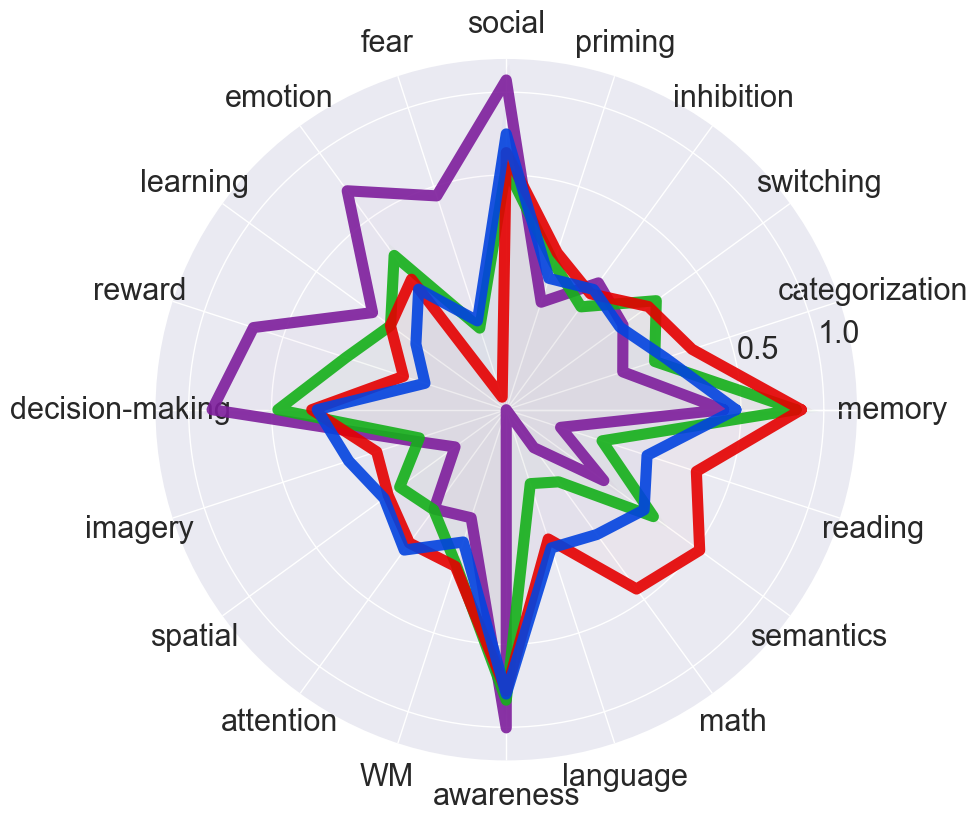

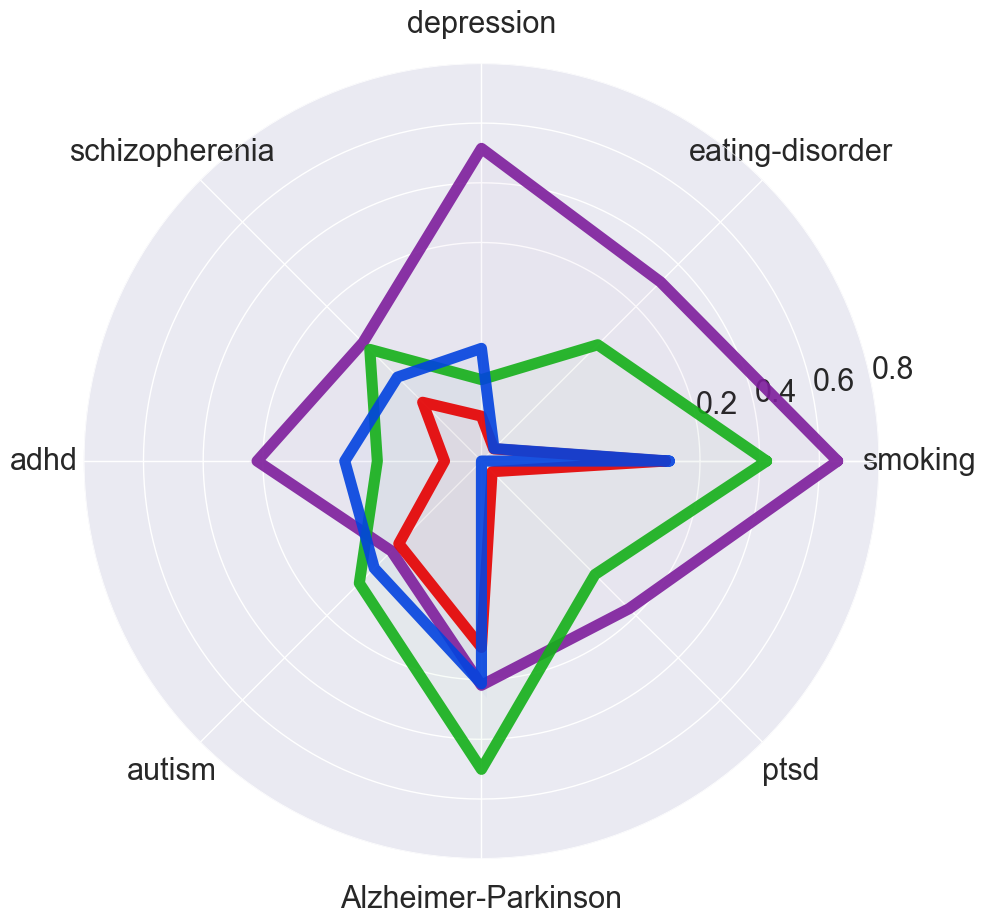

In [7]:
clf = RegionalClassifier(dataset, 'masks/DMN.nii.gz', GaussianNB())
clf.classify(scoring=roc_auc_score)
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)

colors = ["purple","green",'red','blue']
colors = sns.xkcd_palette(colors)

a, b, cog = plot_clf_polar(formated_importances,labels = cognitive_topics, palette = colors, max_val=1.2,label_size=22)
a, b, dis = plot_clf_polar(formated_importances, labels = disease_topics, palette = colors,max_val=0.8,label_size=22)

First, using permute_log_odds_ratio we perform a permutation test for each region - topic log odds ratio, resulting in the z-score and p-value of the observed log odds ratio in permuted null distribution. Small p-values indicate it is inprobably we would observe the given log odds ratio under the null distribution.
Note that this function takes a fitted RegionalClassifier model (that we generated above) and the number of times to resample as required arguments

In [8]:
%load_ext autoreload
%autoreload 1
%aimport classification

In [9]:
# These are the names of each region in the DMN
names_70 = ['MPFC','PCC','lTPJ','rTPJ']

In [10]:
from classification import permute_log_odds
lor_z = classification.permute_log_odds(clf, 1000, feature_names=nicknames.nickname, region_names = names_70)

[##########] 100%


Next, we must adjust the p-values for multiple comparisons. To do so, we will use False Discovery Rate, and focus only on a subject of tests. As such, We are only going to include the topics that we focused on for the above plots.

Finally, we use multipletests from the stats models package to correct our p-values given an alpha of 0.01. We then consider the null hypothesis rejected if the adjusted p-value is less than 0.05 and the sign is positive (excluding less easily interpreted negative associations).

In [11]:
cog_ps = lor_z[lor_z.nickname.isin(cognitive_topics)]
from statsmodels.sandbox.stats.multicomp import multipletests

reject, p_corr, a, a1 = multipletests(cog_ps.p, alpha=0.01, method='fdr_tsbky')

cog_ps['p_corr_01'] = p_corr # Adjusted p-value
cog_ps['reject_01'] = (cog_ps.p_corr_01<0.05) & (cog_ps.lor_z > 0) # Was the null hypothesis rejected?

/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The resulting table includes the FDR corrected p-value for each region/topic combination, and if the null hypothesis has been rejected.

In [12]:
cog_ps.head()

,ROI,nickname,lor_z,p,p_corr_01,reject_01
0,MPFC,social,11.362162,0.000000e+00,0.000000e+00,True
1,PCC,social,5.969696,2.376957e-09,8.231062e-09,True
2,lTPJ,social,7.217025,5.313527e-13,3.219998e-12,True
3,rTPJ,social,7.653515,1.953993e-14,1.353279e-13,True
4,MPFC,attention,-0.748382,4.542299e-01,3.863345e-01,False


We next perform the same analysis on disease-related topics.

In [13]:
dis_ps = lor_z[lor_z.nickname.isin(disease_topics)]

reject, p_corr, a, a1 = multipletests(dis_ps.p, alpha=0.01, method='fdr_tsbky')

dis_ps['p_corr_01'] = p_corr # Adjusted p-value
dis_ps['reject_01'] = (dis_ps.p_corr_01<0.05) & (dis_ps.lor_z > 0)

/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
dis_ps.head()

,ROI,nickname,lor_z,p,p_corr_01,reject_01
12,MPFC,ptsd,1.432308,0.152056,0.198746,False
13,PCC,ptsd,0.066796,0.946744,0.671391,False
14,lTPJ,ptsd,-4.146763,0.000034,0.000187,False
15,rTPJ,ptsd,-3.964601,0.000074,0.000272,False
16,MPFC,adhd,2.083284,0.037225,0.068929,False


### Functional profiles for MPFC

Classifying...
[##########] 100%


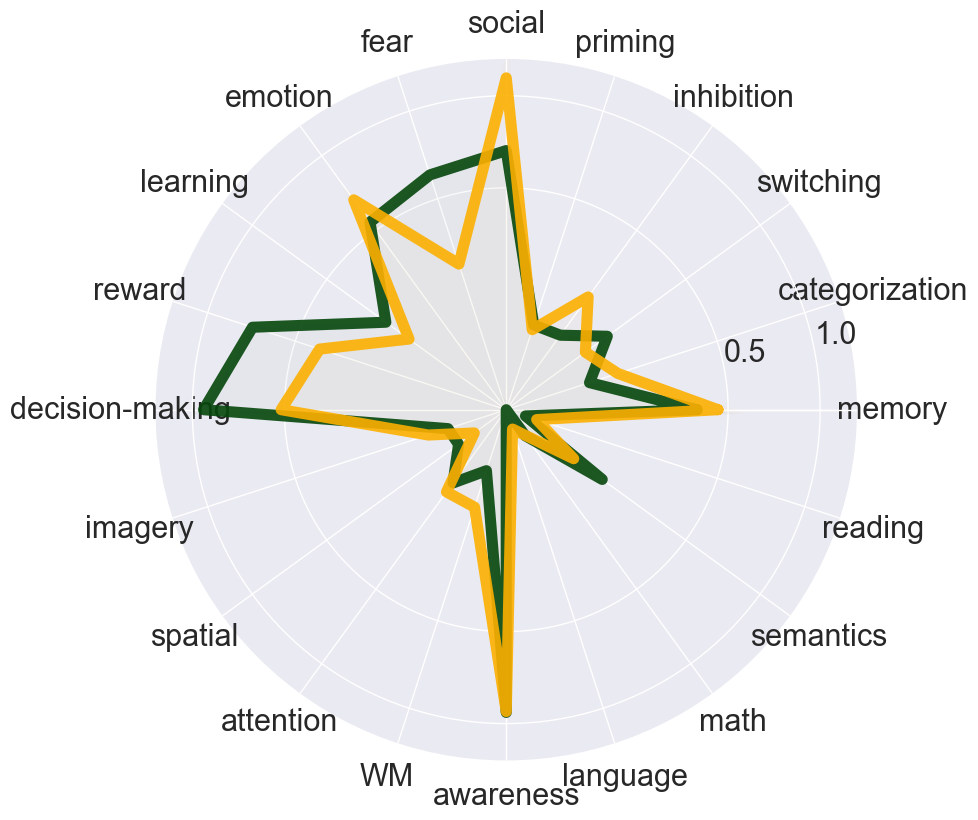

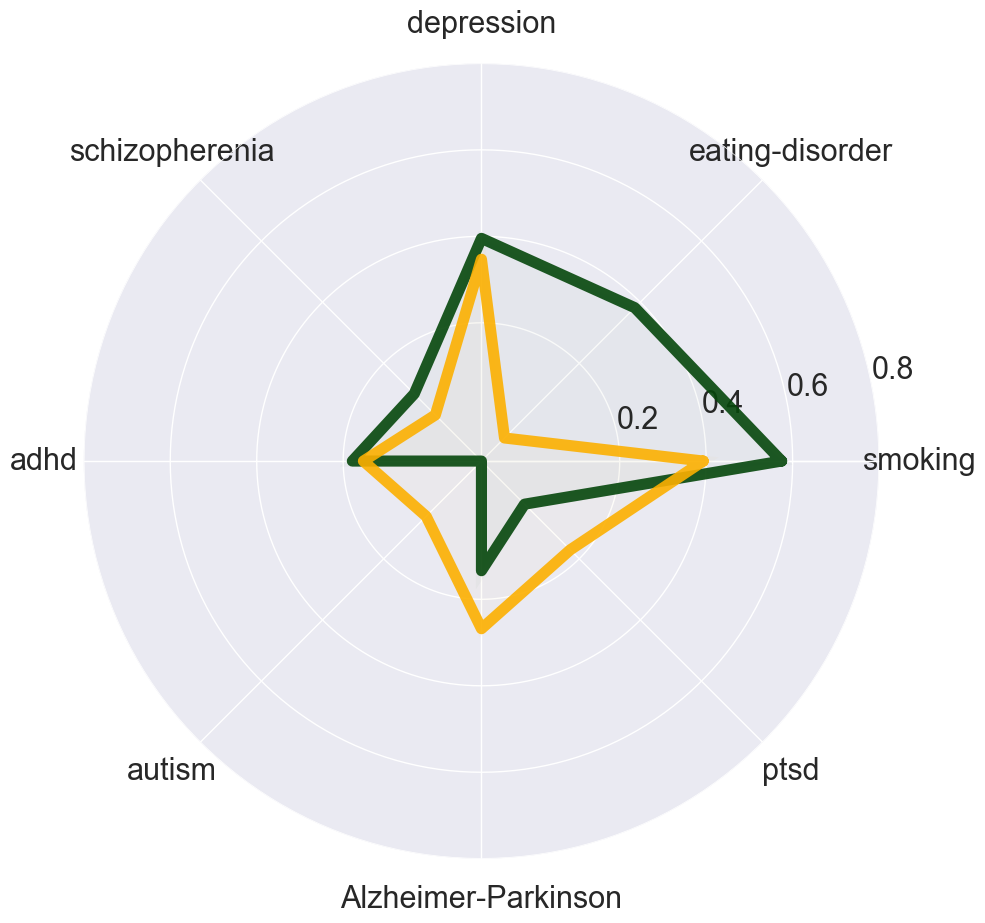

In [15]:
clf = RegionalClassifier(dataset, 'images/MPFC/cluster_labels_k2.nii.gz', GaussianNB())
clf.classify(scoring=roc_auc_score)
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)

colors = ["forest green","yellow orange"]
colors = sns.xkcd_palette(colors)
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)

a, b, cog =plot_clf_polar(formated_importances,labels = cognitive_topics, palette = colors, max_val=1.2,label_size=22)
a, b, dis = plot_clf_polar(formated_importances, labels = disease_topics, palette = colors, max_val=0.8,label_size=22)

In [16]:
# These are the names of each region given the manuscript
names_70 = ['ventral','dorsal'] #MPFC ['posterior','ventral','dorsal']

In [17]:
lor_z = classification.permute_log_odds(clf, 1000, feature_names=nicknames.nickname, region_names = names_70)

[##########] 100%


In [18]:
cog_ps = lor_z[lor_z.nickname.isin(cognitive_topics)]
reject, p_corr, a, a1 = multipletests(cog_ps.p, alpha=0.01, method='fdr_tsbky')

cog_ps['p_corr_01'] = p_corr # Adjusted p-value
cog_ps['reject_01'] = (cog_ps.p_corr_01<0.05) & (cog_ps.lor_z > 0) 
cog_ps.head()

/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ROI,nickname,lor_z,p,p_corr_01,reject_01
0,ventral,social,7.622927,2.486900e-14,1.054943e-13,True
1,dorsal,social,11.312954,0.000000e+00,0.000000e+00,True
2,ventral,attention,-0.890150,3.733854e-01,2.399850e-01,False
3,dorsal,attention,-0.589029,5.558420e-01,3.274836e-01,False
4,ventral,imagery,-2.570718,1.014879e-02,8.610233e-03,False


In [19]:
dis_ps = lor_z[lor_z.nickname.isin(disease_topics)]
reject, p_corr, a, a1 = multipletests(dis_ps.p, alpha=0.01, method='fdr_tsbky')

dis_ps['p_corr_01'] = p_corr # Adjusted p-value
dis_ps['reject_01'] = (dis_ps.p_corr_01<0.05) & (dis_ps.lor_z > 0)
dis_ps.head()

/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ROI,nickname,lor_z,p,p_corr_01,reject_01
6,ventral,ptsd,0.199241,0.842075,0.691027,False
7,dorsal,ptsd,1.429332,0.152909,0.250962,False
8,ventral,adhd,1.628286,0.103464,0.194069,False
9,dorsal,adhd,1.280405,0.200403,0.292365,False
16,ventral,depression,2.882645,0.003944,0.012945,True


### Functional profiles for PCC

Classifying...
[##########] 100%


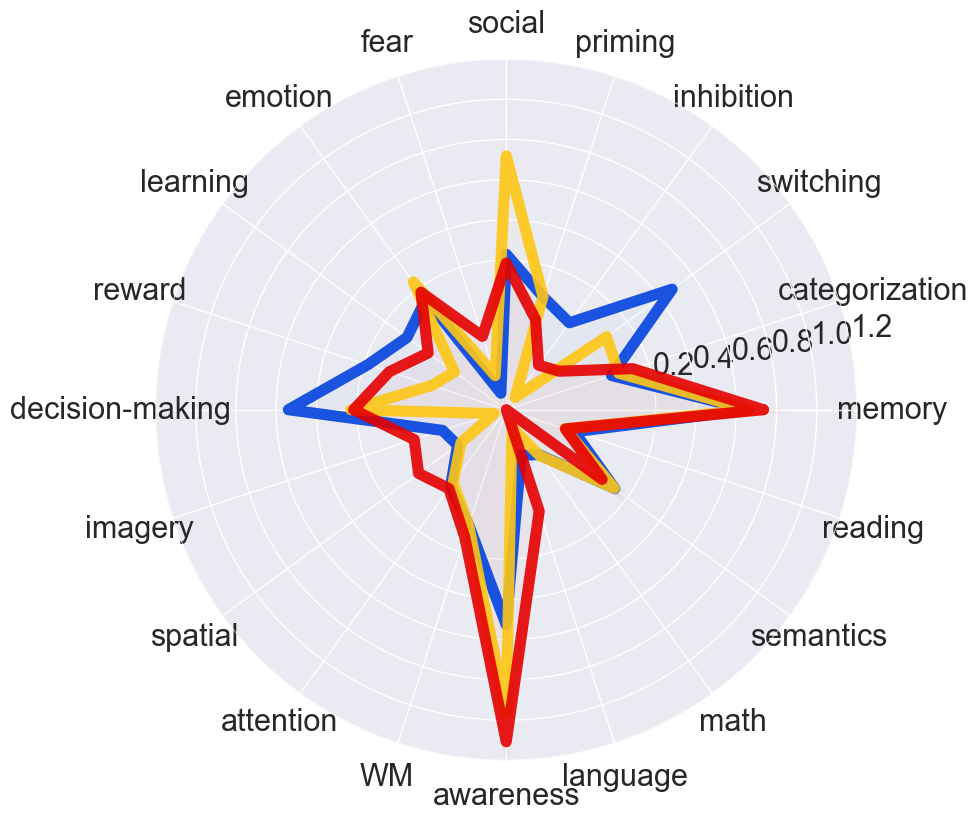

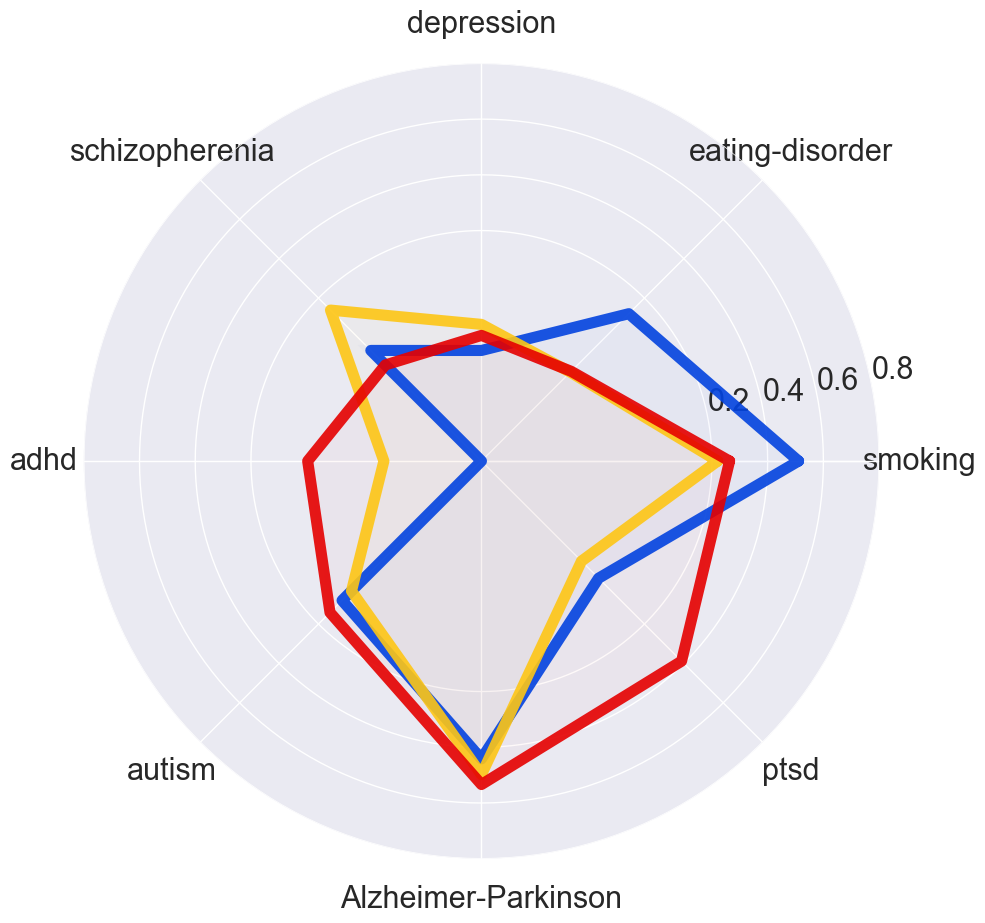

In [20]:
clf = RegionalClassifier(dataset, 'images/PCC/cluster_labels_k3.nii.gz', GaussianNB())
clf.classify(scoring=roc_auc_score)
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)

colors = ["blue","golden yellow","red"]
colors = sns.xkcd_palette(colors)
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)

a, b, cog =plot_clf_polar(formated_importances,labels = cognitive_topics, max_val=1.2,palette = colors,label_size=22)
a, b, dis = plot_clf_polar(formated_importances, labels = disease_topics, max_val=0.8,palette = colors,label_size=22)

In [21]:
# These are the names of each region given the manuscript
names_70 = ['dorsal','medial','ventral'] #PCC

In [22]:
lor_z = classification.permute_log_odds(clf, 1000, feature_names=nicknames.nickname, region_names = names_70)

[##########] 100%


In [23]:
cog_ps = lor_z[lor_z.nickname.isin(cognitive_topics)]

reject, p_corr, a, a1 = multipletests(cog_ps.p, alpha=0.01, method='fdr_tsbky')

cog_ps['p_corr_01'] = p_corr # Adjusted p-value
cog_ps['reject_01'] = (cog_ps.p_corr_01<0.05) & (cog_ps.lor_z > 0) 
cog_ps.head()

/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ROI,nickname,lor_z,p,p_corr_01,reject_01
0,dorsal,social,2.291511,2.193388e-02,6.385339e-02,False
1,medial,social,7.388547,1.485478e-13,1.837908e-12,True
2,ventral,social,1.726008,8.434601e-02,1.614883e-01,False
3,dorsal,attention,-0.206534,8.363742e-01,7.525847e-01,False
4,medial,attention,-0.268644,7.882035e-01,7.237841e-01,False


In [24]:
dis_ps = lor_z[lor_z.nickname.isin(disease_topics)]
reject, p_corr, a, a1 = multipletests(dis_ps.p, alpha=0.01, method='fdr_tsbky')

dis_ps['p_corr_01'] = p_corr # Adjusted p-value
dis_ps['reject_01'] = (dis_ps.p_corr_01<0.05) & (dis_ps.lor_z > 0)
dis_ps.head()

/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ROI,nickname,lor_z,p,p_corr_01,reject_01
9,dorsal,ptsd,-0.165857,0.868270,0.838824,False
10,medial,ptsd,-0.865680,0.386666,0.491286,False
11,ventral,ptsd,2.636561,0.008375,0.035742,True
12,dorsal,adhd,-4.658032,0.000003,0.000035,False
13,medial,adhd,-2.101969,0.035556,0.098757,False


### Functional profiles for left-TPJ

Classifying...
[##########] 100%


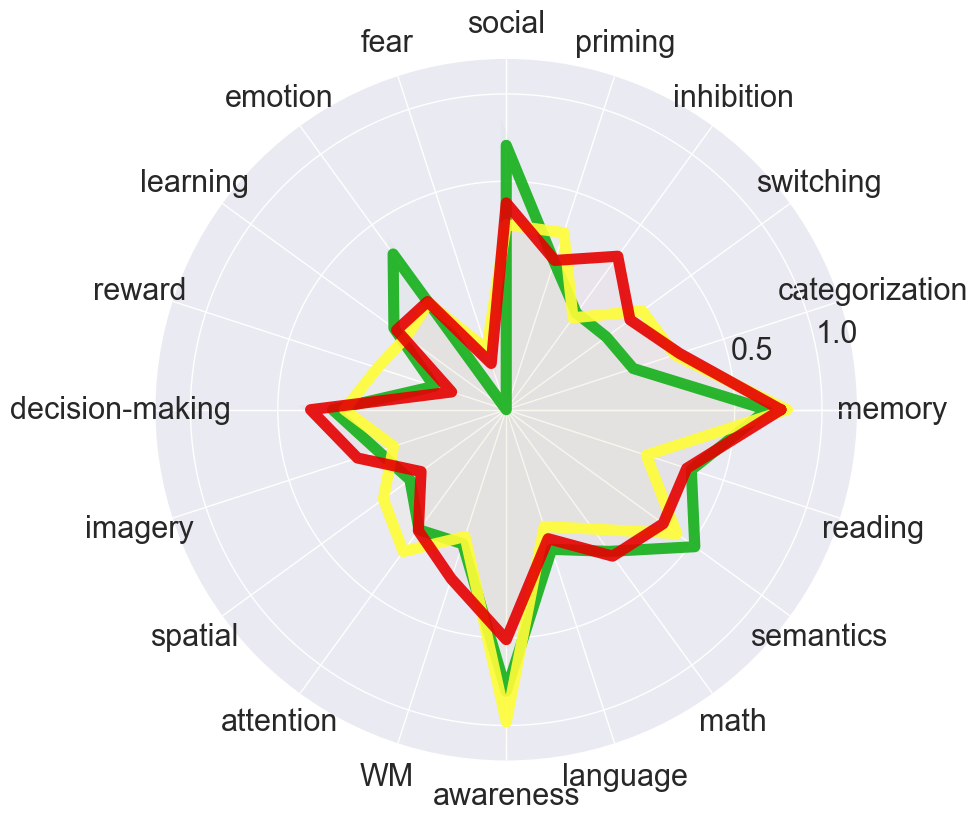

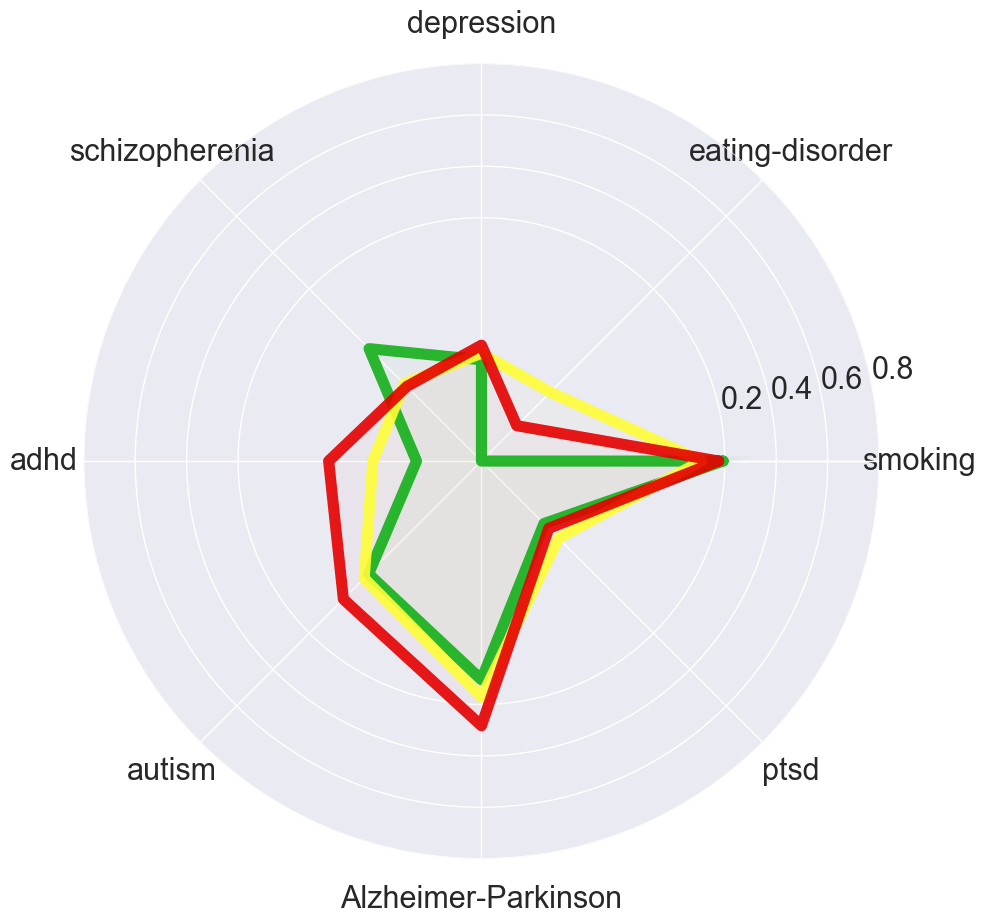

In [25]:
clf = RegionalClassifier(dataset, 'images/lTPJ/cluster_labels_k3.nii.gz', GaussianNB())
clf.classify(scoring=roc_auc_score)
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)

colors = ["green","sunshine yellow","red"]
colors = sns.xkcd_palette(colors)
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)

a, b, cog =plot_clf_polar(formated_importances,labels = cognitive_topics, max_val=1.2,palette = colors,label_size=22)
a, b, dis = plot_clf_polar(formated_importances, labels = disease_topics, max_val=0.8,palette = colors,label_size=22)

In [26]:
# These are the names of each region given the manuscript
names_70 = ['ventral','posterior','dorsal']#['ventral','dorsal','medial'] #lTPJ

In [27]:
lor_z = classification.permute_log_odds(clf, 1000, feature_names=nicknames.nickname, region_names = names_70)

[##########] 100%


In [28]:
cog_ps = lor_z[lor_z.nickname.isin(cognitive_topics)]
reject, p_corr, a, a1 = multipletests(cog_ps.p, alpha=0.01, method='fdr_tsbky')

cog_ps['p_corr_01'] = p_corr # Adjusted p-value
cog_ps['reject_01'] = (cog_ps.p_corr_01<0.05) & (cog_ps.lor_z > 0) # Was the null hypothesis rejected?
cog_ps.head()

/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ROI,nickname,lor_z,p,p_corr_01,reject_01
0,ventral,social,7.360452,1.831868e-13,2.651934e-12,True
1,posterior,social,2.446998,1.440517e-02,2.979126e-02,True
2,dorsal,social,3.911192,9.184171e-05,3.188673e-04,True
3,ventral,attention,0.263190,7.924041e-01,6.570725e-01,False
4,posterior,attention,0.866315,3.863176e-01,4.934639e-01,False


In [29]:
dis_ps = lor_z[lor_z.nickname.isin(disease_topics)]
reject, p_corr, a, a1 = multipletests(dis_ps.p, alpha=0.01, method='fdr_tsbky')

dis_ps['p_corr_01'] = p_corr # Adjusted p-value
dis_ps['reject_01'] = (dis_ps.p_corr_01<0.05) & (dis_ps.lor_z > 0)
dis_ps.head()

/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ROI,nickname,lor_z,p,p_corr_01,reject_01
9,ventral,ptsd,-3.018393,0.002541,0.013475,False
10,posterior,ptsd,-2.059340,0.039462,0.083698,False
11,dorsal,ptsd,-2.728879,0.006355,0.022465,False
12,ventral,adhd,-3.701984,0.000214,0.001512,False
13,posterior,adhd,-2.223361,0.026191,0.077499,False


### Functional profiles for right-TPJ

Classifying...
[##########] 100%


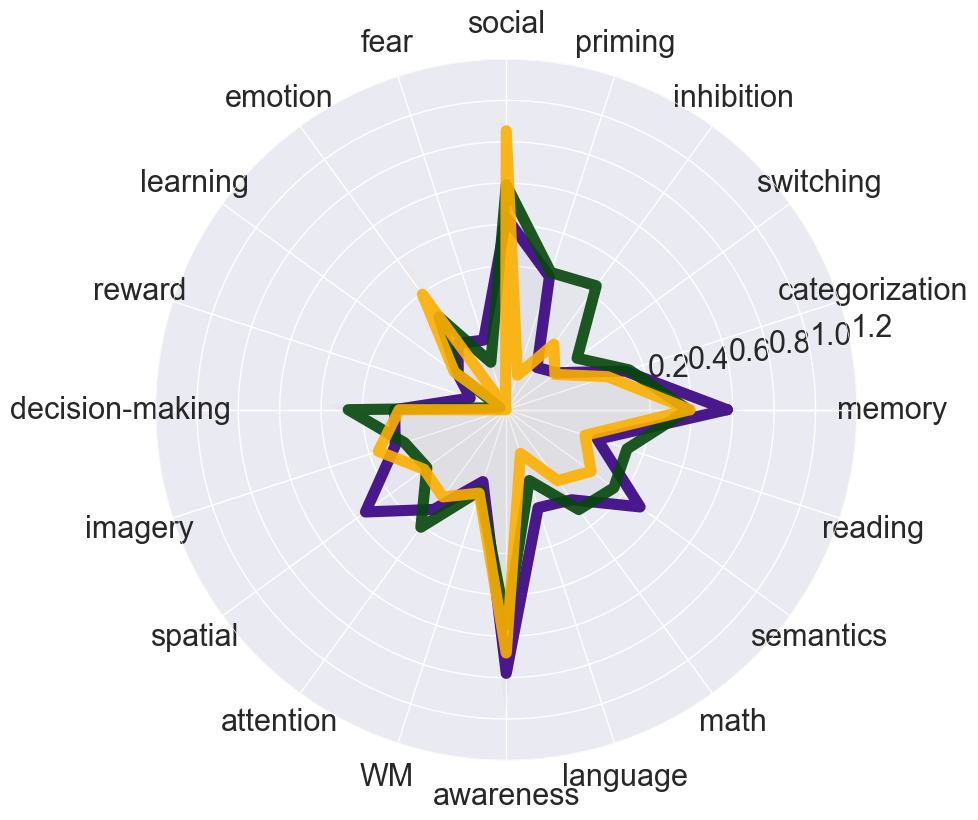

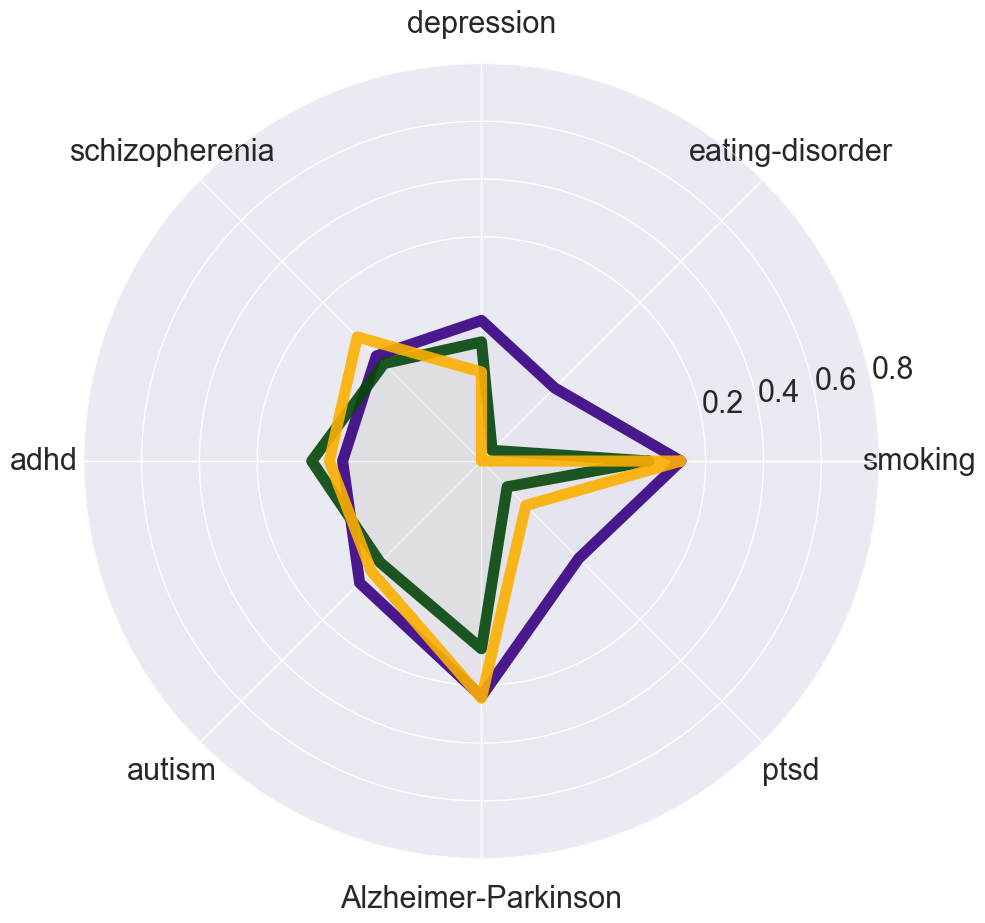

In [30]:
clf = RegionalClassifier(dataset, 'images/rTPJ/cluster_labels_k3.nii.gz', GaussianNB())
clf.classify(scoring=roc_auc_score)
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)

colors = ["indigo","forest green","yellow orange"]
colors = sns.xkcd_palette(colors)
formated_importances = clf.get_formatted_importances(feature_names=nicknames.nickname)

a, b, cog =plot_clf_polar(formated_importances,labels = cognitive_topics, max_val=1.2,palette = colors,label_size=22)
a, b, dis = plot_clf_polar(formated_importances, labels = disease_topics, max_val=0.8,palette = colors,label_size=22)

In [ ]:
# These are the names of each region given the manuscript
names_70 = ['posterior','dorsal','ventral']#['ventral','dorsal','lateral'] #rTPJ

In [ ]:
lor_z = classification.permute_log_odds(clf, 1000, feature_names=nicknames.nickname, region_names = names_70)

[##########] 100%


In [ ]:
cog_ps = lor_z[lor_z.nickname.isin(cognitive_topics)]
reject, p_corr, a, a1 = multipletests(cog_ps.p, alpha=0.01, method='fdr_tsbky')

cog_ps['p_corr_01'] = p_corr # Adjusted p-value
cog_ps['reject_01'] = (cog_ps.p_corr_01<0.05) & (cog_ps.lor_z > 0) # Was the null hypothesis rejected?
cog_ps.head()

/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ROI,nickname,lor_z,p,p_corr_01,reject_01
0,posterior,social,3.764575,1.668327e-04,1.432259e-03,True
1,dorsal,social,5.311950,1.084586e-07,1.862235e-06,True
2,ventral,social,7.858654,3.774758e-15,9.721890e-14,True
3,posterior,attention,0.474915,6.348474e-01,6.843843e-01,False
4,dorsal,attention,0.980020,3.270760e-01,5.578549e-01,False


In [ ]:
dis_ps = lor_z[lor_z.nickname.isin(disease_topics)]
reject, p_corr, a, a1 = multipletests(dis_ps.p, alpha=0.01, method='fdr_tsbky')

dis_ps['p_corr_01'] = p_corr # Adjusted p-value
dis_ps['reject_01'] = (dis_ps.p_corr_01<0.05) & (dis_ps.lor_z > 0)
dis_ps.head()

/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shaomingwang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ROI,nickname,lor_z,p,p_corr_01,reject_01
9,posterior,ptsd,-0.601339,0.547614,0.843519,False
10,dorsal,ptsd,-2.928802,0.003403,0.025203,False
11,ventral,ptsd,-2.310047,0.020886,0.116019,False
12,posterior,adhd,-0.505067,0.613512,0.843519,False
13,dorsal,adhd,0.117558,0.906418,0.867558,False
